In [13]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import pandas as pd
import os
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.prepared import prep
from shapely.geometry import Point

In [8]:
def transform_coords(lon, lat, projection):
    x, y = projection.transform_point(lon, lat, ccrs.PlateCarree())
    return x, y

def polygon_masking(grid_x,grid_y,shapefile):
    x_flt = grid_x.flatten()
    y_flt = grid_y.flatten()

    # Prepare shapefiles for processing
    geom = shapefile.geometry.union_all()
    p_geom = prep(geom)

    # Use flattened x and y coordinates to find points within the polygon
    mask_flt = np.array([p_geom.contains(Point(x, y)) for x, y in zip(x_flt, y_flt)])
    # Reshape the mask back to the original array shape
    mask = mask_flt.reshape(grid_x.shape)

    return(mask)

In [9]:
# Define the custom Lambert Azimuthal Equal Area projection
map_projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-105,central_latitude=74)

# Coordinates to transform (lon, lat) in the Plate Carree projection
geo_extent = [-140, -70, 64, 79]


# Get corners of 'bounding box' from geo_extent
corners = [
    (geo_extent[0], geo_extent[2]),  # SW corner
    (geo_extent[1], geo_extent[2]),  # SE corner
    (geo_extent[0], geo_extent[3]),  # NW corner
    (geo_extent[1], geo_extent[3])   # NE corner
]

# Transform coordinates to the desired map area
proj_corners = [transform_coords(lon, lat, map_projection) for lon, lat in corners]
x_coords, y_coords = zip(*proj_corners)

x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

grid_spacing = 25000 # 25 km

x_grid_centre = np.arange(x_min-grid_spacing/2,x_max + grid_spacing/2, grid_spacing)
y_grid_centre = np.arange(y_min-grid_spacing/2,y_max + grid_spacing/2, grid_spacing)
new_x_centre, new_y_centre = np.meshgrid(x_grid_centre, y_grid_centre) # For PMV & CIS data (regridded)


# Ice motion

In [16]:
# Locate Directory & shapefiles to crop to region

im_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/IceMotion/Regridded_MonthlyMean_Arrays/')

bs_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BeaufortSea_Shapefile.shp')
bb_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BaffinBay_Shapefile.shp')

regions = {'BS':bs_shp,'BB':bb_shp}
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

motion_regional_means = []
for region, shapefile in regions.items():
    mask = polygon_masking(new_x_centre,new_y_centre,shapefile)
    for month in months:
        mean_gridded_speed = np.load(im_directory+str(month)+'_Mean_Speed_Regridded.npy')

        # mask regions
        motion_masked_data = np.where(mask,mean_gridded_speed,np.nan)

        # Save the means to an array
        motion_mean = np.nanmean(motion_masked_data)

        # Convert to km/day 
        motion_mean_km = motion_mean * 0.864
        motion_regional_means.append({'Region':region,'Month':month,'Km Mean':motion_mean_km})

# Air Temperature

In [18]:
# Locate Directory
temp_data_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/Gridded_AirTemp/')

# Import shapefiles of the desired regions - for temperature use ocean ones
bs_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BeaufortSea_Ocean_Shapefile.shp')
caa_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/Central_CAA_Ocean_Shapefile.shp')
bb_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BaffinBay_Ocean_Shapefile.shp')

regions = {'BS':bs_shp,'CAA':caa_shp,'BB':bb_shp}
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

temp_regional_means = []

for region, shapefile in regions.items():
    mask = polygon_masking(new_x_centre,new_y_centre,shapefile)
    for month in months:
        mean_air_temp = np.load(temp_data_directory+str(month)+'_CA_Mean_AirTemperature.npy')

        # mask regions
        temp_masked_data = np.where(mask,mean_air_temp,np.nan)

        # Save the means to an array
        temp_mean = np.nanmean(temp_masked_data)
        temp_regional_means.append({'Region':region,'Month':month,'Mean':temp_mean})

# SIC Variability

In [19]:
pmv_std_mean_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/PMV_Daily_Std_MonthlyMean/')

# Import shapefiles of the desired regions
bs_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BeaufortSea_Shapefile.shp')
caa_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/Central_CAA_Shapefile.shp')
bb_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BaffinBay_Shapefile.shp')

regions = {'BS':bs_shp,'CAA':caa_shp,'BB':bb_shp}
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

std_regional_means = []

for region, shapefile in regions.items():
    mask = polygon_masking(new_x_centre,new_y_centre,shapefile)
    for month in months:
        mean_sic_std = np.load(pmv_std_mean_directory+str(month)+'_PMV_Mean_Std_Array.npy')
        # mask regions
        std_masked_data = np.where(mask,mean_sic_std,np.nan)

        # Save the means to an array
        std_mean = np.nanmean(std_masked_data)
        std_regional_means.append({'Region':region,'Month':month,'Mean':std_mean})

# Plot

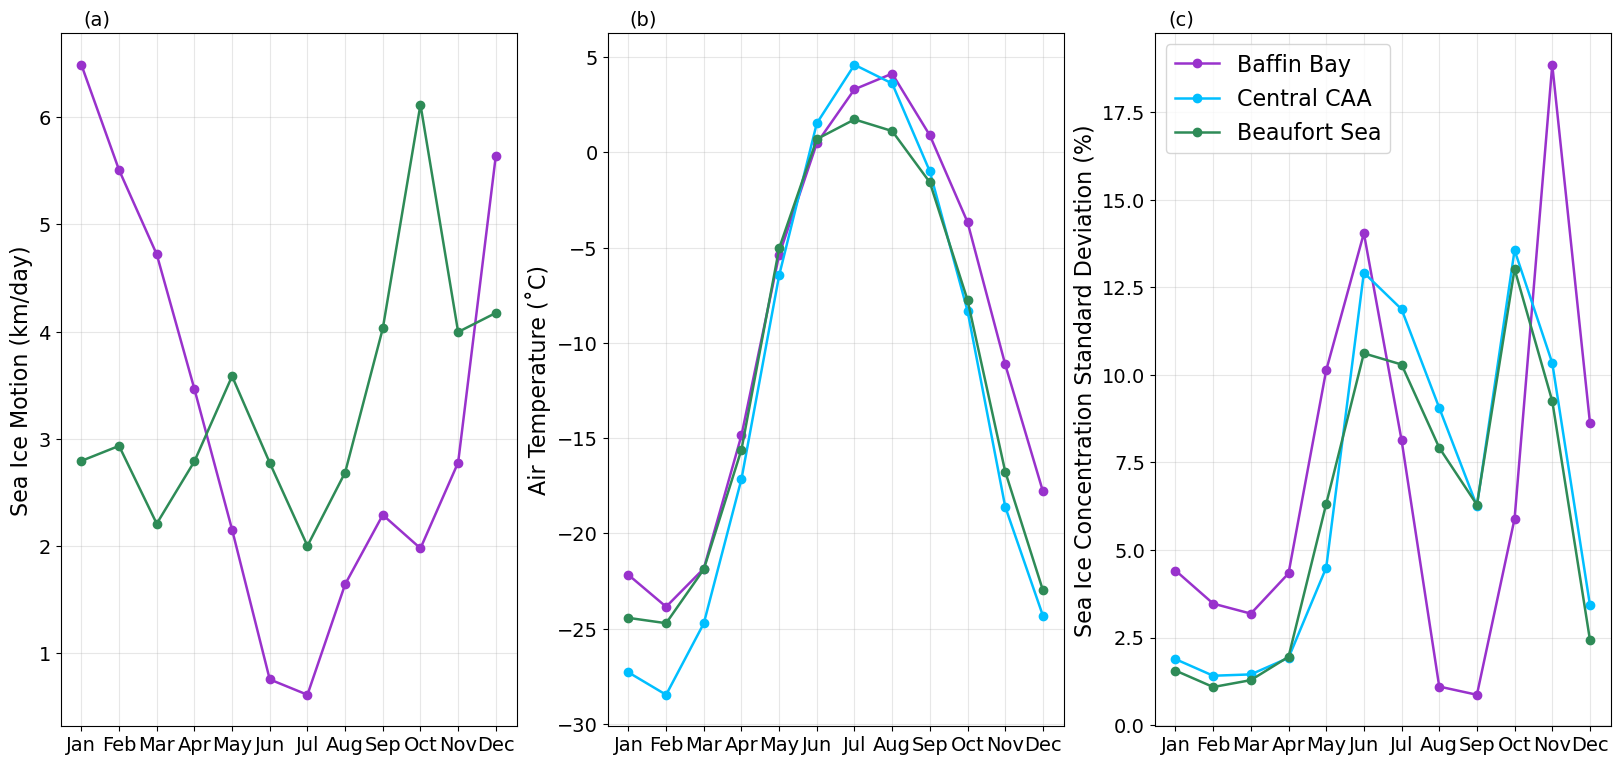

In [21]:
months = [entry['Month'] for entry in std_regional_means]
regions = [entry['Region'] for entry in std_regional_means]
std_means = [entry['Mean'] for entry in std_regional_means]
temp_means = [entry['Mean'] for entry in temp_regional_means]

region_colors = {'BS': 'seagreen', 'CAA': 'deepskyblue', 'BB': 'darkorchid'}
full_region_names = {'BS': 'Beaufort Sea', 'CAA': 'Central CAA', 'BB': 'Baffin Bay'}

# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=[20, 9])
plt.rcParams.update({'font.size': 14})

x_x = ['01','02','03','04','05','06','07','08','09','10','11','12']
x_offset = {'BS': -0.2, 'CAA': 0.0, 'BB': 0.2} 

legend_handles, legend_labels = [],[]

for region in set(regions):
    region_months = [months[i] for i in range(len(months)) if regions[i] == region]
    std_regions_means = [std_means[i] for i in range(len(std_means)) if regions[i] == region]
    x_shifted = [x_x.index(month) + x_offset[region] for month in region_months]

    plot = ax[2].plot(x_x,std_regions_means,color=region_colors[region],
                       marker='o',linewidth = 1.8,linestyle='-',label=region)

    temp_regions_means = [temp_means[i] for i in range(len(temp_means)) if regions[i] == region]
    line, = ax[1].plot(x_x,temp_regions_means,color=region_colors[region],
                       marker='o',linewidth = 1.8,linestyle='-',label=region)
    
    legend_handles.append(line)
    legend_labels.append(full_region_names[region])

# Ice motion data not available in central CAA
im_months = [entry['Month'] for entry in motion_regional_means]
im_regions = [entry['Region'] for entry in motion_regional_means]
im_means = [entry['Km Mean'] for entry in motion_regional_means]
im_region_colors = {'BS': 'seagreen', 'BB': 'darkorchid'}
im_x_offset = {'BS': -0.1, 'BB': 0.1}

for im_region in set(im_regions):
    region_months = [im_months[i] for i in range(len(im_months)) if im_regions[i] == im_region]
    im_regions_means = [im_means[i] for i in range(len(im_means)) if im_regions[i] == im_region]
    im_x_shifted = [x_x.index(month) + im_x_offset[im_region] for month in region_months]

    plot = ax[0].plot(x_x,im_regions_means,color=im_region_colors[im_region],
                    marker='o',linewidth = 1.8,linestyle='-',label=im_region)

ax[0].set_ylabel('Sea Ice Motion (km/day)',fontsize=16)
ax[1].set_ylabel('Air Temperature (˚C)',fontsize=16) 
ax[2].set_ylabel('Sea Ice Concentration Standard Deviation (%)',fontsize=16) 

ax[2].legend(legend_handles, legend_labels, fontsize=16, loc='upper left')

for i in range(3):
    ax[i].xaxis.grid(True, 'major', alpha=0.3)
    ax[i].yaxis.grid(True, 'major', alpha=0.3)

    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])


plt.text(-29,20,'(a)',fontsize=14)
plt.text(-14.5,20,'(b)',fontsize=14)
plt.text(-0.2,20,'(c)',fontsize=14)

plt.show()
fig.savefig('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC_Plots/ReSubmission_Plots/Fig08_TemporalVariabiltiy.png',dpi=300,bbox_inches="tight")